In [22]:
# uses conda environment gpflow6_0

# generic
import numpy as np
import pandas as pd
import xarray as xr
from itertools import product
import time

# plotting
import seaborn as sns
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.lines import Line2D 
from matplotlib.patches import Circle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import gpflow as gpf
from gpflow.ci_utils import ci_niter, ci_range
from gpflow.utilities import print_summary

# tensorflow
import tensorflow as tf

#debug
from IPython.core.debugger import set_trace

from eu_functions import *
import os
import warnings; warnings.simplefilter('ignore')

In [103]:
####################  Initialize parameters #######################

ice_model = "d6g_h6g_"
lith = 'l71C'
tmax = 12000
tmin = 100
agemax = round(tmax, -3) + 100
agemin = round(tmin, -3) 
place = 'denmark_netherlands'

ages = np.arange(agemin, agemax, 100)[::-1]

locs = {
        'northsea_uk': [-10, 10, 45, 60],
        'northsea_uk_tight': [-5, 10, 48, 57],
        'english_channel': [-5, 2, 48, 52],
        'denmark_netherlands': [3, 12, 52, 56],
        'north_england':[-5, 2.5, 53, 56],
        'europe_arctic': [-15, 88, 45, 85],
       }
extent = locs[place]

##Get Norway data sheet from Google Drive
sheet = 'Norway_isolation'
df_nor = load_nordata_fromsheet(sheet, fromsheet=False)

#import khan dataset
path = '../../data/GSL_LGM_120519_.csv'
df_place = import_rsls(path, df_nor, tmin, tmax, extent)

# # add zeros at present-day.  
# nout = 50
# df_place = add_presday_0s(df_place, nout)

# #####################  Make xarray template  #######################

filename = '../../data/xarray_template.mat'
ds_template = xarray_template(filename, ages, extent)

#####################    Load GIA datasets   #######################
path = f'../../data/{ice_model}/output_{ice_model}{lith}'
ds = make_mod(path, ice_model, lith, ages, extent)

likelist = []
namelist = []
wrsslist = []
rmselist = []
wrmselist = []

ds_load = ds.load().chunk((-1,-1,-1)).interp(lon=ds_template.lon, lat=ds_template.lat).to_dataset()

# for speed, just select 2
ds_load = ds_load.sel(modelrun=['d6g_h6g_l71C_ump4_lm50', 
#                                 'd6g_h6g_l71C_ump4_lm40',
#                                 'd6g_h6g_l71C_ump5_lm20',
#                                 'd6g_h6g_l71C_ump2_lm9',
#                                 'd6g_h6g_l71C_ump4_lm30', 
#                                 'd6g_h6g_l71C_ump4_lm20',
#                                 'd6g_h6g_l71C_ump5_lm15', 
#                                 'd6g_h6g_l71C_ump4_lm7',                   
#                                 'd6g_h6g_l71C_ump5_lm50', 
#                                 'd6g_h6g_l71C_ump3_lm5',
                               ])

In [104]:
path = f'../../data/NWEuropeLIGDatabase_v4.csv'
df_lig = pd.read_csv(path, header=1)
df_lig.rename(columns={'Longitude':'lon',
                        'Latitude':'lat',
                        'Relative Sea \nLevel (m)':'rsl',
                        'RSL Error \n(1σ m)':'rsl_er',
                        'Age\n(ka BP)':'age',
                      'Age Error\n(1σ ka)':'age_er'}, inplace=True)

df_lig = df_lig[(df_lig.lon > extent[0])
               & (df_lig.lon < extent[1])
               & (df_lig.lat > extent[2])
               & (df_lig.lat < extent[3])]

In [95]:
#####################    Run Iterative GP Regression   ##################

for i, ds_single in ds_load.groupby('modelrun'):

    #interpolate/select priors from GIA model
    df_place['rsl_giaprior'] = df_place.apply(lambda row: ds_select(ds_single, row), axis=1)
    df_place['age_giaprior'] = df_place.apply(lambda row: ds_ageselect(ds_single, row), axis=1)
    
    #calculate residuals
    df_place['rsl_realresid'] = df_place.rsl - df_place.rsl_giaprior
    df_place['age_realresid'] = df_place.age - df_place.age_giaprior
#     df_place['rsl_realresid_rmse'] = df_place.rsl - df_place.rsl_giaprior
    
    # Calculate weighted root mean squared error and weighted residual sum of squares
    df_place['wrss'] = (df_place.age_realresid/df_place.age_er)**2 + (df_place.rsl_realresid/df_place.rsl_er)**2
    
    wrss = df_place.wrss.sum()
    
    weights = df_place.rsl_er/df_place.rsl_er.sum()
    rmse = np.sqrt((df_place.rsl_realresid ** 2).sum()/len(df_place))
    wrmse = np.sqrt((df_place.rsl_realresid ** 2/weights).sum()/len(df_place))

    
    print('number of datapoints = ', df_place.shape)
    
    ##################	  RUN GP REGRESSION 	#######################
    ##################  --------------------	 ######################


    k1 = 50
    k2 = 10000
    k3 = 5000
    k4 = 10000

    iterations = 1000
    nout = 40
    name = ds_single.modelrun.values.tolist()[0]

    ds_giapriorinterp, da_zp, ds_priorplusgpr, ds_varp, loglike, m, df_place = run_gpr(nout, iterations, ds_single, ages, k1, k2, k3, k4, df_place)
    
    likelist.append(loglike)
    namelist.append(name)
    wrsslist.append(wrss)
    rmselist.append(rmse)
    wrmselist.append(wrmse)
    
    path_gen = f'output/{place}_{name}_{ages[0]}_{ages[-1]}'
    da_zp.to_netcdf(path_gen + '_dazp')
    ds_giapriorinterp.to_netcdf(path_gen + '_giaprior')
    ds_priorplusgpr.to_netcdf(path_gen + '_posterior')
    ds_varp.to_netcdf(path_gen + '_gpvariance')
    
    # calculate posterior RMSE
    df_place['rsl_posterior'] = df_place.apply(lambda row: ds_select(ds_priorplusgpr, row), axis=1)
    df_place['rsl_posteriorresid'] = df_place.rsl - df_place.rsl_posterior

    
    rmse_posterior = np.sqrt((df_place.rsl_posteriorresid ** 2).sum()/len(df_place))
    
    
df_out = pd.DataFrame({'modelrun': namelist,
             'log_marginal_likelihood': likelist,
                      'weighted residual sum of squares': wrsslist,
                      'root mean squared error': rmselist,
                      'weighted root mean squared error': wrmselist,
                      'root mean squared error posterior': rmse_posterior})


KeyboardInterrupt: 

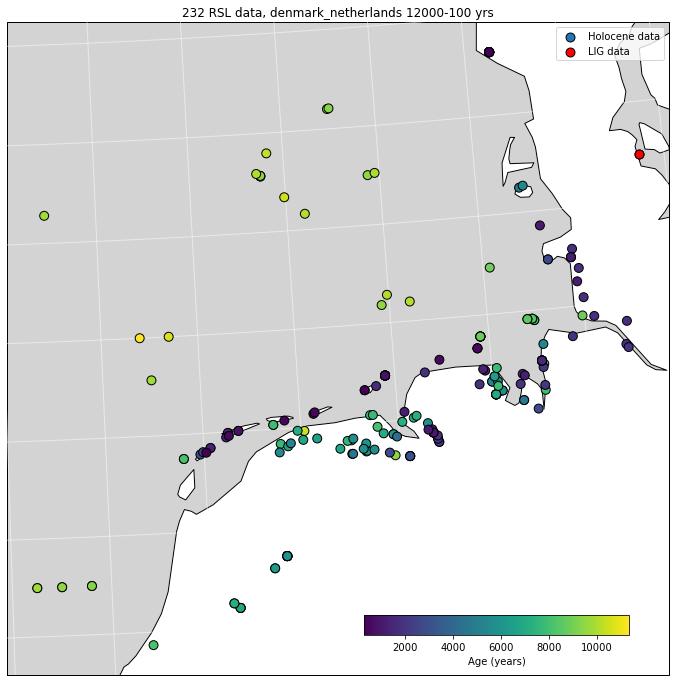

In [105]:
projection = ccrs.LambertConformal(central_longitude=0)
trans = ccrs.PlateCarree()
fig, ax = plt.subplots(1, 1, figsize=(12, 12), subplot_kw=dict(projection=projection))

ocean_50m = cfeature.NaturalEarthFeature('physical', 'ocean', '50m')
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m')

ax.add_feature(ocean_50m, color='lightgray', zorder=0)
ax.add_feature(land_50m, color='white', zorder=1)
ax.gridlines(linewidth=1, color='white', alpha=0.5, zorder=4)
ax.coastlines(resolution='50m')

# ax.set_extent([-10, 10, 45, 60])
# ax.set_extent([-5, 10, 50, 55])

scat = ax.scatter(df_place.lon, df_place.lat, s=80, c = df_place.age, 
                  cmap='viridis', edgecolor='k', linewidths=1, 
                  transform=trans, zorder=5, label='Holocene data')

scat2 = ax.scatter(df_lig.lon, df_lig.lat, s=80, c = 'r', 
                   edgecolor='k', linewidths=1, 
                  transform=trans, zorder=5, label='LIG data')

cbaxes = inset_axes(ax, width="40%", height="3%", loc=4, borderpad=4,) 
cbar = fig.colorbar(scat, ax=ax, cax=cbaxes, shrink=.5,
                    label='Age (years)', 
                   orientation='horizontal')

ax.set_title(f'{len(df_place)} RSL data, {place} {tmax}-{tmin} yrs')
ax.legend();

# fig.savefig('/Users/rogercreel/Desktop/dataplot_fennoscandia')

To Do: 
Make GPR models of all Ice6g, Lev, and Lev + Patton models for this region
for: 

1.  All of data
2.  Regional subsets (SW UK + NW France; Lowlands; Denmark) 
3.  Only data around LIG data constraints (concentric expansions) 

# Visualize outputs

In [12]:
ds_gia = ds_giapriorinterp
ds_zp = da_zp
ds_post = ds_priorplusgpr
ds_var = ds_varp


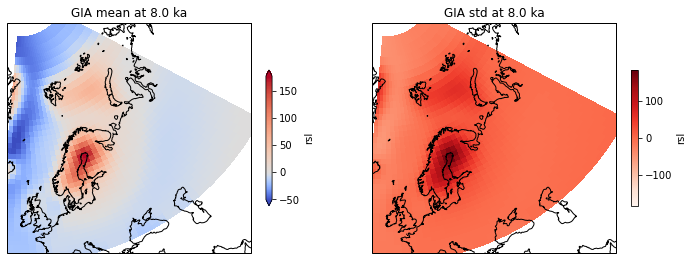

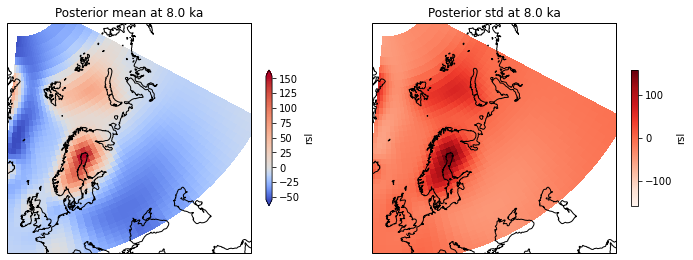

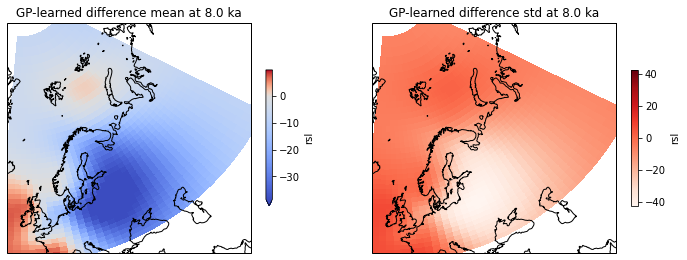

In [13]:
# Load models
# starttime=12000
# ds_var = xr.open_mfdataset(glob.glob(f'output/*{starttime}*variance*'), combine='nested', concat_dim=['model'])
# ds_zp = xr.open_mfdataset(glob.glob(f'output/*{starttime}*zp*'), combine='nested', concat_dim=['model'])
# ds_gia = xr.open_mfdataset(glob.glob(f'output/*{starttime}*prior*'), combine='nested', concat_dim=['model'])
# ds_post = xr.open_mfdataset(glob.glob(f'output/*{starttime}*post*'), combine='nested', concat_dim=['model'])

# make plotting convenience functions

def plot_fig(title, ds, age, topscale=0, bottomscale=0):
    proj = ccrs.LambertConformal(central_longitude=-10)
    fig, ax = plt.subplots(1, 2, figsize=(12, 5), subplot_kw=dict(projection=proj))
    ax = ax.flatten()
    
    ax[0].coastlines(resolution='50m')
    ax[0].set_extent(extent)
    mean = ds.mean(dim='modelrun').load().rsl.sel(age=age, method='nearest')
    std = ds.std(dim='modelrun').load().rsl.sel(age=age, method='nearest')
    
    if ds.equals(ds_gia):
        mean = mean.transpose()
        std = std.transpose()
             
    vmin = mean.min().values + bottomscale
    vmax = mean.max().values - topscale
    
    mean.plot(ax=ax[0],
              transform=ccrs.PlateCarree(), 
              cmap='coolwarm',
              norm = MidpointNormalize(vmin, vmax, 0),
             cbar_kwargs={'shrink': 0.5})
    
    ax[0].set_title(f'{title} mean at {age/1000} ka') 
    
    
    ax[1].coastlines(resolution='50m')
    ax[1].set_extent(extent)  
    
    vmin = std.min().values
    vmax = std.max().values
    
    std.plot(ax=ax[1],
             transform=ccrs.PlateCarree(), 
             cmap='Reds',
#              norm = MidpointNormalize(vmin, vmax, 0),
             cbar_kwargs={'shrink': 0.5}
            )
    
    ax[1].set_title(f'{title} std at {age/1000} ka')    
    
    return 

plot_fig('GIA', ds_gia, 8000, topscale=5, bottomscale=2)
plot_fig('Posterior', ds_post, 8000, topscale=5, bottomscale=2)
plot_fig('GP-learned difference', ds_zp, 8000, topscale=0, bottomscale=4)

# Find largest likelihood

In [28]:
def read_csv(f):
    df = pd.read_csv(f)
    df['k'] = ['k1', 'k2', 'k3', 'k4', 'k5']
    return df

path = 'output/'                  
starttime = 10000
param_files = glob.glob(os.path.join(path, f"*{starttime}*params.csv"))

metric_files = glob.glob(os.path.join(path, f"*{starttime}*metrics.csv"))

df_params = pd.concat((read_csv(f) for f in param_files), ignore_index=True)
df_mets = pd.concat((pd.read_csv(f) for f in metric_files), ignore_index=True)

# find largest likelihood
path = 'output/'
largestlike = df_mets[df_mets.log_marginal_likelihood == df_mets.log_marginal_likelihood.min()].modelrun.values[0]
bestrmse = df_mets[df_mets['root mean squared error'] == df_mets['root mean squared error'].min()].modelrun.values[0]

def find_largestlike_model(which, largestlike):
    files = glob.glob(os.path.join(path, f'*{which}'))
    matching = [s for s in files if largestlike in s]
    return xr.open_dataset(matching[0])

# find GIA model of largest likelihood 
ds_gialargest = find_largestlike_model('prior', largestlike)

# find posterior model of largest likelihood 
ds_postlargest = find_largestlike_model('posterior', largestlike)

ds_gialargest = find_largestlike_model('prior', bestrmse)

# find posterior model of largest likelihood 
ds_postlargest = find_largestlike_model('posterior', bestrmse)

plt.scatter(-df_mets.log_marginal_likelihood, df_mets['weighted root mean squared error'])
plt.title(f'{ice_model} {place} {tmax} - {tmin} \n Log marginal likelihood vs. RMSE')
plt.xlabel('likelihood')
plt.ylabel('RMSE');

ValueError: No objects to concatenate

# Plot timeseries

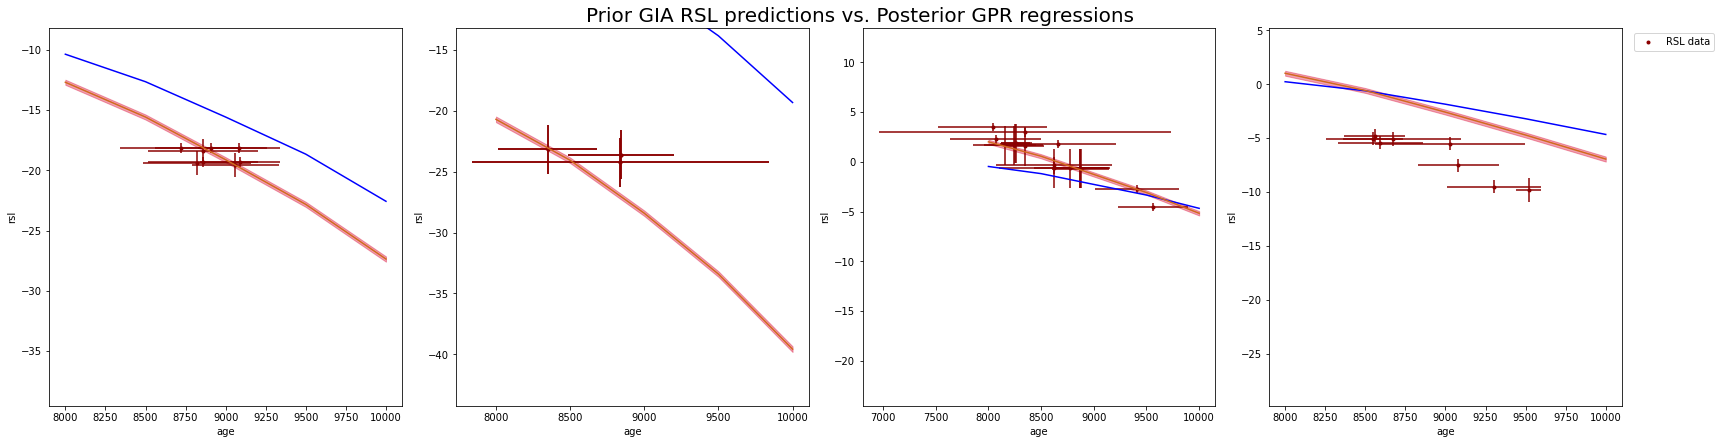

In [20]:
projection = ccrs.PlateCarree()
# trans = ccrs.AlbersEqualArea(central_longitude=40)
trans = ccrs.LambertConformal(central_longitude=-10)

colormark = ['blue', 'chocolate', 'darkred', 'crimson', 'olivedrab']

number=5

df_nufsamps = locs_with_enoughsamples(df_place, place, number)
nufsamp = df_nufsamps.locnum.unique()


def interp_ds(ds):
    return ds.interp(age=ds_giamean.age, lat=ds_giamean.lat, lon=ds_giamean.lon)

def slice_dataset(ds):
    return ds.rsl.sel(lat=site[1].lat.unique() ,
                  lon=site[1].lon.unique(),
                  method='nearest').sel(age=slice(tmax, tmin)).squeeze()


#### Plot  #####

# fig, ax = plt.subplots(1,len(nufsamp), figsize=(20, 6), subplot_kw=dict(projection=projection))
# ax = ax.ravel()

# da_zeros = xr.zeros_like(ds_gia.rsl[0,:,:,0])

# for i, site in enumerate(df_nufsamps.groupby('locnum')):
# #     ax[i].set_extent([-12, 25, 47, 72])
#     ax[i].set_extent(extent)

#     ax[i].coastlines(color='k')
#     ax[i].plot(site[1].lon.unique(),
#                site[1].lat.unique(),
#                c=colormark[0],
#                ms=7,
#                marker='o',
#                transform=projection)
#     ax[i].plot(site[1].lon.unique(),
#                site[1].lat.unique(),
#                c=colormark[0],
#                ms=25,
#                marker='o',
#                transform=projection,
#                mfc="None",
#                mec='red',
#                mew=4)
#     da_zeros.plot(ax=ax[i], cmap='Greys', add_colorbar=False, transform=projection)

#     ax[i].set_title('')

    
fig, ax = plt.subplots(1, len(nufsamp), figsize=(24, 6))
ax = ax.ravel()

for i, site in enumerate(df_nufsamps.groupby('locnum')):
    
#     #slice data for each site
    prior = slice_dataset(ds_gia) 

    post = slice_dataset(ds_post)
    var = slice_dataset(np.sqrt(ds_var))
    top = post + var * 2
    bottom = post - var * 2
    
    site_err = 2 * (site[1].rsl_er)
    age_err = 2 * site[1].age_er
    
#     giabestlike = slice_dataset(ds_gialargestlike)
#     postbestlike = slice_dataset(ds_postlargestlike)
    
#     giabestrmse = slice_dataset(ds_gialargestrmse)
#     postbestrmse = slice_dataset(ds_postlargestrmse)    
    
    prior.plot.line(ax=ax[i], 
                    x='age', 
                    color=colormark[0], 
                    alpha=1, 
                    add_legend=False);
#     giabestlike.plot.line(ax=ax[i], color=colormark[0], lw=2, ls='-', label='prior maximum likelihood')
#     giabestrmse.plot.line(ax=ax[i], color=colormark[0], lw=2, ls='--', label='prior lowest rmse')

    ax[i].fill_between(post.age, bottom.squeeze(), top.squeeze(), color=colormark[3], alpha=0.4) 
    
    post.plot.line(ax=ax[i],
                   x='age',
                   color=colormark[1],
                   alpha=1, 
                   add_legend=False);

#     postbestlike.plot.line(ax=ax[i],
#                            color='k',
#                            lw=2, 
#                            ls='-', 
#                            label='best posterior likelihood')
#     postbestrmse.plot.line(ax=ax[i], 
#                            color='k',
#                            lw=2,
#                            ls='--',
#                            label='best posterior rmse'
#                           )
    
    ax[i].scatter(site[1].age, 
                  site[1].rsl, 
                  c=colormark[2],
                  s=4, 
                  lw=2,
                  label='RSL data'
                 )
    ax[i].errorbar(site[1].age, 
                   site[1].rsl, 
                   yerr=site_err,
                   xerr=age_err, 
                   c=colormark[2],
                   fmt='none', 
                   capsize=-.1,
                   lw=1.5
                  )

#     ax[i].set_xlim(0, 12000)
    ax[i].set_ylim(site[1].rsl.min() - 20,site[1].rsl.max()+10)
    ax[i].set_title('')

# Set legend outside frame 
# see https://stackoverflow.com/questions/30413789/matplotlib-automatic-legend-outside-plot
lgd = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

plt.gcf().canvas.draw()
invFigure = plt.gcf().transFigure.inverted()

lgd_pos = lgd.get_window_extent()
lgd_coord = invFigure.transform(lgd_pos)
lgd_xmax = lgd_coord[1, 0]

ax_pos = plt.gca().get_window_extent()
ax_coord = invFigure.transform(ax_pos)
ax_xmax = ax_coord[1, 0]

shift = 1 - (lgd_xmax - ax_xmax)
plt.gcf().tight_layout(rect=(0, 0, shift, 1))

plt.suptitle(f"Prior GIA RSL predictions vs. Posterior GPR regressions", fontsize=20, y=1.02)

plt.tight_layout()

In [ ]:
# look at sites for last 3000 years

# Explore hyperparameters

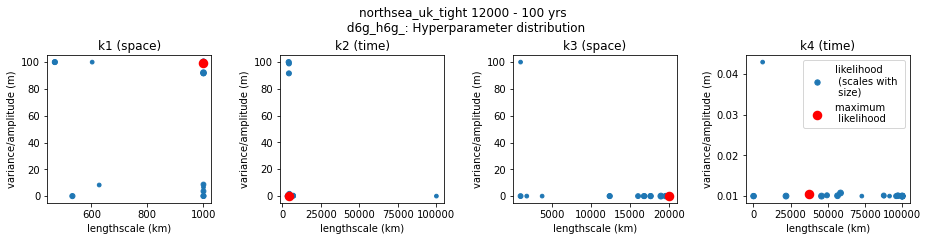

In [35]:
def get_k(df_params, k_it):
    return df_params[df_params['k'] == k_it]

def maxlike(k):
    return k[k.model == largestlike]
    

ks = ['k1', 'k2', 'k3', 'k4']
parenth = ['space', 'time', 'space', 'time']

fig, ax = plt.subplots(1, 4, figsize=(13, 3))
ax = ax.flatten()
for i, ax in enumerate(ax):
    k = get_k(df_params, ks[i])
    ml = maxlike(k)
    
    ax.scatter(k.lengthscale, 
               k.variance,
              s=10000/k.likelihood,
              label='likelihood \n (scales with \n size)')
    ax.scatter(ml.lengthscale, 
               ml.variance, 
               s=10000/ml.likelihood,
               c='r', 
               lw=3,
               label='maximum \n likelihood')
    ax.set_xlabel('lengthscale (km)')
    ax.set_ylabel('variance/amplitude (m)')
    ax.set_title(f'{ks[i]} ({parenth[i]})')

plt.legend()
plt.tight_layout()
plt.suptitle(f'{place} {tmax} - {tmin} yrs \n {ice_model}: Hyperparameter distribution', y=1.1);

# Make Heatmaps

In [25]:
def splitNames(df):

    df['ice_model'] = [key.split('_l')[0] for key in df.modelrun]
    df['lith'] = [key.split('_')[-3:][0] for key in df.modelrun]
    df['um'] = [key.split('_')[-3:][1][-1] for key in df.modelrun]
    df['lm'] = [key.split('_')[-3:][2][2:] for key in df.modelrun]
    df.lm = df.lm.astype(float)
    df.um = df.um.astype(float)
    
    return df

df_plt = splitNames(df_mets)
df_plt['log_marginal_likelihood'] = -df_plt.log_marginal_likelihood

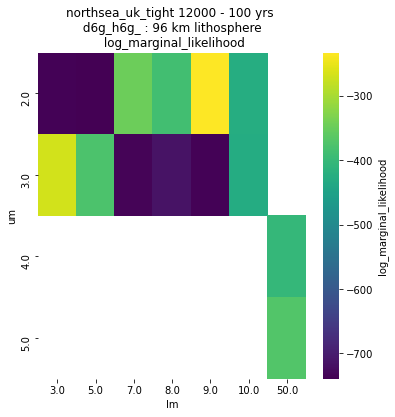

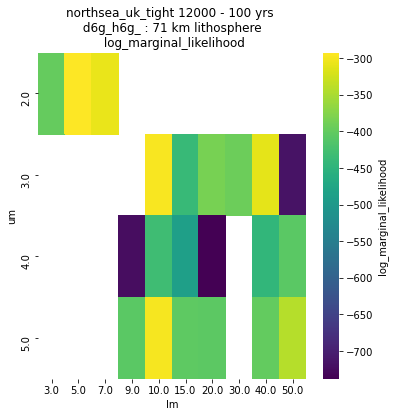

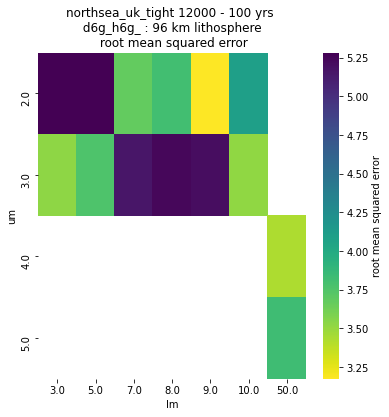

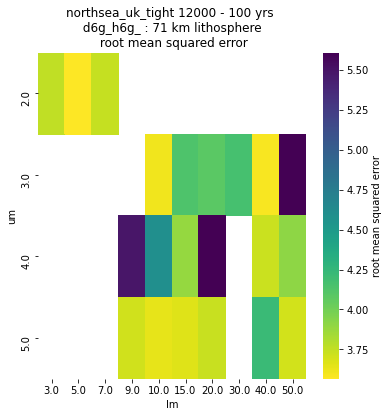

In [26]:


def make_heatmap(df, model, lith, values):
    
    heatmap = df.pivot_table(index='um', columns='lm', values=values)

    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    if values == 'log_marginal_likelihood':
        cmap='viridis'
    else:
        cmap='viridis_r'
    sns.heatmap(heatmap,  cmap=cmap, ax=ax,
                cbar_kws={'label': f'{values}'})

    ax.set_title(f'{place} {tmax} - {tmin} yrs \n {model} : {lith} km lithosphere \n {values}')
    plt.show()
    
df_96 = df_plt[df_plt.lith == 'l96C']
df_71 = df_plt[df_plt.lith == 'l71C']
    
make_heatmap(df_96, 'd6g_h6g_', '96', 'log_marginal_likelihood')
make_heatmap(df_71, 'd6g_h6g_', '71', 'log_marginal_likelihood')

other =  'root mean squared error' # 'weighted residual sum of squares' #
make_heatmap(df_96, 'd6g_h6g_', '96', other)
make_heatmap(df_71, 'd6g_h6g_', '71', other )


In [ ]:
# Load data

ds_varp = xr.open_dataset(glob.glob('output/*variance')[0])
ds_zp = xr.open_dataset(glob.glob('output/*zp')[0]).rename({'__xarray_dataarray_variable__':'rsl'}) #remove when fixed as dataset
ds_giamean = xr.open_dataset(glob.glob('output/*prior')[0])
ds_priorplusgpr = xr.open_dataset(glob.glob('output/*posterior')[0])

In [ ]:
proj = ccrs.PlateCarree()

colormark = ['blue', 'chocolate', 'darkred', 'crimson', 'olivedrab']
cmaps = cmap_codes('viridis', len(df_nufsamps))


number=11

df_nufsamps = locs_with_enoughsamples(df_place, place, number)
nufsamp = df_nufsamps.locnum.unique()

def interp_ds(ds):
    return ds.interp(age=ds_giamean.age, lat=ds_giamean.lat, lon=ds_giamean.lon)

def slice_dataset(ds):
    return ds.rsl.sel(lat=site[1].lat.unique() ,
                  lon=site[1].lon.unique(),
                  method='nearest').sel(age=slice(tmax, tmin))


###### Plot  #####

fig, ax = plt.subplots(1,len(nufsamp), figsize=(20, 6), subplot_kw=dict(projection=projection))
ax = ax.ravel()

da_zeros = xr.zeros_like(ds_giamean.rsl[:,:,0])

for i, site in enumerate(df_nufsamps.groupby('locnum')):
    ax[i].set_extent(extent)
    ax[i].coastlines(color='k')
    ax[i].plot(site[1].lon.unique(),
               site[1].lat.unique(),
               c=colormark[0],
               ms=7,
               marker='o',
               transform=trans)
    ax[i].plot(site[1].lon.unique(),
               site[1].lat.unique(),
               c=colormark[0],
               ms=25,
               marker='o',
               transform=trans,
               mfc="None",
               mec='red',
               mew=4)
    da_zeros.plot(ax=ax[i], cmap='Greys', add_colorbar=False)

    ax[i].set_title('')

    
num = 6
fig, ax = plt.subplots(1, len(nufsamp), figsize=(20, 6))
ax = ax.ravel()

for i, site in enumerate(df_nufsamps.groupby('locnum')):
    
    plt.suptitle(f"Prior GIA RSL predictions vs. Posterior GPR regressions", fontsize=20)

#     #slice data for each site
    prior_it = slice_dataset(ds_giamean) 

    post_it = slice_dataset(ds_priorplusgpr)
    var_it = slice_dataset(np.sqrt(ds_varp))
    top = post_it + var_it * 2
    bottom = post_it - var_it * 2
    
    site_err = 2 * (site[1].rsl_er)
    age_err = 2 * site[1].age_er

    prior_it.plot(ax=ax[i], c=colormark[0], alpha=1, label='ICE6G GIA prior')


    ax[i].fill_between(post_it.age, bottom.squeeze(), top.squeeze(), color=colormark[3], alpha=0.4) 
    post_it.plot(ax=ax[i], lw=2, c=colormark[1], alpha=1, label='ICE6G GPR posterior')

    
    ax[i].scatter(site[1].age, site[1].rsl, c=colormark[2], s=4, lw=2,label='RSL data')
    ax[i].errorbar(site[1].age, site[1].rsl, yerr=site_err, xerr=age_err, c=colormark[2], fmt='none', capsize=-.1,lw=1.5)

    ax[i].set_xlim(0, 12000)
    ax[i].set_ylim(site[1].rsl.min() - 20,site[1].rsl.max()+10)
    ax[i].set_title('')
#     if i > num:
#         break

lines = [ Line2D([0], [0], color=colormark[0], linewidth=3, linestyle='-'),
         Line2D([0], [0], color=colormark[1], linewidth=3, linestyle='-'),
         Circle([0], 0.1, color=colormark[2], linewidth=3, ec="none")]

labels = ['ICE6G GIA prior', 'ICE6G GPR posterior', 'RSL data']
ax[i].legend(lines, labels, loc='lower left')


plt.show()